In [ ]:
#default_exp event

# The events API

> Helpers for getting GitHub API events

In [ ]:
#export
from fastcore.utils import *
from fastcore.foundation import *
from fastcore.meta import *
from ghapi.core import *
from ghapi.page import *
from ghapi.actions import *

import time,json,gzip
from itertools import islice

In [ ]:
#hide
from nbdev.showdoc import show_doc
from IPython.display import Markdown
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
api = GhApi()

In [ ]:
#export
def _list_events(g, username=None, org=None, owner=None, repo=None):
    if (username or org or owner) and \
        not (bool(username) ^ bool(org) ^ bool(owner)): raise Exception('Can not pass more than one of username, org, and owner')
    if (owner and not repo): owner,repo = repo.split('/')
    if owner: return g.list_public_events_for_repo_network,{'owner':owner,'repo':repo}
    if org: return g.list_public_org_events,{'org':org}
    if username: return g.list_public_events_for_user,{'username':username}
    return g.list_public_events,{}

In [ ]:
#export
def _id2int(x):
    x.id = int(x.id)
    return x

In [ ]:
#export
@patch
@delegates(_list_events)
def list_events(self:GhApi, per_page=30, page=1, **kwargs):
    "Fetch public events for repo network, org, user, or all"
    oper,kw = _list_events(self.activity, **kwargs)
    return oper(per_page=per_page, page=page, **kw).map(_id2int)

In [ ]:
#export
@patch
@delegates(_list_events)
def list_events_parallel(self:GhApi, per_page=30, n_pages=8, **kwargs):
    "Fetch as many events from `list_events` in parallel as available"
    oper,kw = _list_events(self.activity, **kwargs)
    return pages(oper, n_pages, per_page=per_page, **kw).concat().map(_id2int)

`list_events` and `list_events_parallel` support the following:

|Events from|Example|
|:-|:-|
|Organization|`api.list_events_parallel(org='fastai')`
|User|`api.list_events_parallel(username='jph00')`
|Repository network|`api.list_events_parallel(owner='fastai', repo='fastcore')`
|All public|`api.list_events_parallel()`

In [ ]:
#export
_bot_re = re.compile('b[o0]t')
def _want_evt(o, types, incl_bot):
    if not incl_bot and _bot_re.search(nested_attr(o, 'actor.login') or ''): return False
    if types and o.type not in types: return False
    return True

In [ ]:
#export
class GhEvent(AttrDict):
    "Class for events returned from `fetch_events"
    pass

for o in Event: exec(f'class {snake2camel(o)}Event(GhEvent):pass')

In [ ]:
show_doc(GhEvent, title_level=4)

<h4 id="GhEvent" class="doc_header"><code>class</code> <code>GhEvent</code><a href="" class="source_link" style="float:right">[source]</a></h4>

> <code>GhEvent</code>() :: `AttrDict`

Class for events returned from `fetch_events

In [ ]:
print([snake2camel(o)+'Event' for o in Event])

['PageBuildEvent', 'ContentReferenceEvent', 'RepositoryImportEvent', 'CreateEvent', 'WorkflowRunEvent', 'DeleteEvent', 'OrganizationEvent', 'SponsorshipEvent', 'ProjectColumnEvent', 'PushEvent', 'ContextEvent', 'MilestoneEvent', 'ProjectCardEvent', 'ProjectEvent', 'PackageEvent', 'PullRequestEvent', 'RepositoryDispatchEvent', 'TeamAddEvent', 'WorkflowDispatchEvent', 'MemberEvent', 'MetaEvent', 'CodeScanningAlertEvent', 'PublicEvent', 'NeedsEvent', 'CheckRunEvent', 'SecurityAdvisoryEvent', 'PullRequestReviewCommentEvent', 'OrgBlockEvent', 'CommitCommentEvent', 'WatchEvent', 'MarketplacePurchaseEvent', 'StarEvent', 'InstallationRepositoriesEvent', 'CheckSuiteEvent', 'GithubAppAuthorizationEvent', 'TeamEvent', 'StatusEvent', 'RepositoryVulnerabilityAlertEvent', 'PullRequestReviewEvent', 'LabelEvent', 'InstallationEvent', 'ReleaseEvent', 'IssuesEvent', 'RepositoryEvent', 'GollumEvent', 'MembershipEvent', 'DeploymentEvent', 'DeployKeyEvent', 'IssueCommentEvent', 'PingEvent', 'DeploymentStat

In [ ]:
#export
_all_ = [
    'PageBuildEvent', 'ContentReferenceEvent', 'RepositoryImportEvent', 'CreateEvent', 'WorkflowRunEvent', 'DeleteEvent', 'OrganizationEvent',
    'SponsorshipEvent', 'ProjectColumnEvent', 'PushEvent', 'ContextEvent', 'MilestoneEvent', 'ProjectCardEvent', 'ProjectEvent', 'PackageEvent',
    'PullRequestEvent', 'RepositoryDispatchEvent', 'TeamAddEvent', 'WorkflowDispatchEvent', 'MemberEvent', 'MetaEvent', 'CodeScanningAlertEvent',
    'PublicEvent', 'NeedsEvent', 'CheckRunEvent', 'SecurityAdvisoryEvent', 'PullRequestReviewCommentEvent', 'OrgBlockEvent',
    'CommitCommentEvent', 'WatchEvent', 'MarketplacePurchaseEvent', 'StarEvent', 'InstallationRepositoriesEvent', 'CheckSuiteEvent',
    'GithubAppAuthorizationEvent', 'TeamEvent', 'StatusEvent', 'RepositoryVulnerabilityAlertEvent', 'PullRequestReviewEvent', 'LabelEvent',
    'InstallationEvent', 'ReleaseEvent', 'IssuesEvent', 'RepositoryEvent', 'GollumEvent', 'MembershipEvent', 'DeploymentEvent', 'DeployKeyEvent',
    'IssueCommentEvent', 'PingEvent', 'DeploymentStatusEvent', 'ForkEvent', 'ScheduleEvent']

In [ ]:
#export
def _cast_evt(o): return globals()[o.type](o)

In [ ]:
#export
@patch
@delegates(_list_events)
def fetch_events(self:GhApi, n_pages=3, pause=0.4, per_page=30, types=None, incl_bot=False, **kwargs):
    "Generate an infinite stream of events, optionally filtered to `types, with `pause` seconds between requests"
    seen = set()
    if types: types=setify(types or None)
    g = globals()
    while True:
        evts = self.list_events_parallel(n_pages=n_pages, per_page=per_page, **kwargs)
        new_evts = L(_cast_evt(o) for o in evts if o.id not in seen and _want_evt(o, types, incl_bot))
        seen.update(new_evts.attrgot('id'))
        yield from new_evts
        if pause: time.sleep(pause)

In [ ]:
#export
def load_sample_events():
    "Load sample events, downloading if needed"
    name = 'sample_evts.json.gz'
    url = f'https://raw.githubusercontent.com/fastai/ghapi/master/examples/{name}'
    try: path = Path(__file__).parent
    except NameError: path = Path()/'examples'
    path = path/name
    if not path.exists():path.write_bytes(urlread(url, decode=False))
    return dict2obj(json.load(open_file(path))).map(_cast_evt)

In [ ]:
#export
def save_sample_events(n=5000):
    "Save the most recent `n` events as compressed JSON"
    evts = list(islice(api.fetch_events(incl_bot=True), n))
    with gzip.open('sample_evts.json.gz', 'wt') as f: json.dump(obj2dict(evts), f)

In [ ]:
#export
#hide
@patch(as_prop=True)
def full_type(self:GhEvent):
    "Concatenation of `type` and `payload.action` (if available)"
    act = getattr(self.payload, 'action', '')
    return f'{self.type}_{act}' if act else self.type

5000 sample events (taken from a single recent period) are available, and are downloaded and cached by `load_sample_events`. `full_type` provides the combination of `type` and `payload.action` (where available) for each event. Here's the frequency of all `full_types` in the sample:

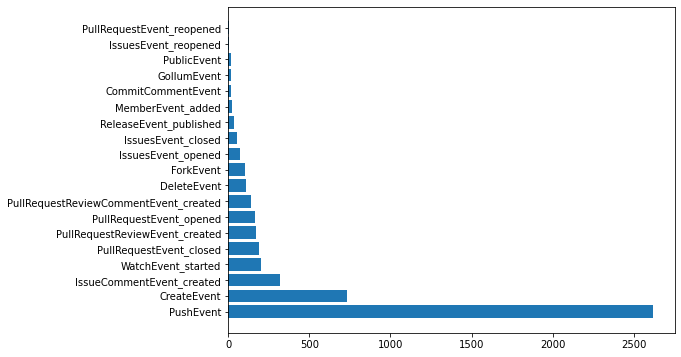

In [ ]:
evts = load_sample_events()
x,y = zip(*Counter([o.full_type for o in evts]).most_common())
plt.figure(figsize=(8, 6))
plt.barh(x,y);

In [ ]:
#export
_all_ = ['PageBuildEvent', 'ContentReferenceEvent', 'RepositoryImportEvent', 'CreateEvent', 'WorkflowRunEvent', 'DeleteEvent', 'OrganizationEvent', 'SponsorshipEvent', 'ProjectColumnEvent', 'PushEvent', 'ContextEvent', 'MilestoneEvent', 'ProjectCardEvent', 'ProjectEvent', 'PackageEvent', 'PullRequestEvent', 'RepositoryDispatchEvent', 'TeamAddEvent', 'WorkflowDispatchEvent', 'MemberEvent', 'MetaEvent', 'CodeScanningAlertEvent',     'PublicEvent', 'NeedsEvent', 'CheckRunEvent', 'SecurityAdvisoryEvent', 'PullRequestReviewCommentEvent', 'OrgBlockEvent', 'CommitCommentEvent', 'WatchEvent', 'MarketplacePurchaseEvent', 'StarEvent', 'InstallationRepositoriesEvent', 'CheckSuiteEvent', 'GithubAppAuthorizationEvent', 'TeamEvent', 'StatusEvent', 'RepositoryVulnerabilityAlertEvent', 'PullRequestReviewEvent', 'LabelEvent', 'InstallationEvent', 'ReleaseEvent', 'IssuesEvent', 'RepositoryEvent', 'GollumEvent', 'MembershipEvent', 'DeploymentEvent', 'DeployKeyEvent', 'IssueCommentEvent', 'PingEvent', 'DeploymentStatusEvent', 'ForkEvent', 'ScheduleEvent']

In [ ]:
#export
evt_emojis = dict(
    PushEvent=                             '⭐',
    CreateEvent=                           '🏭',
    IssueCommentEvent_created=             '💬',
    WatchEvent_started=                    '👀',
    PullRequestEvent_closed=               '📪',
    PullRequestReviewEvent_created=        '💌',
    PullRequestEvent_opened=               '📬',
    PullRequestReviewCommentEvent_created= '🗨',
    DeleteEvent=                           '✂',
    ForkEvent=                             '🍽',
    IssuesEvent_opened=                    '🐛',
    IssuesEvent_closed=                    '🎁',
    ReleaseEvent_published=                '🚀',
    MemberEvent_added=                     '💃',
    CommitCommentEvent=                    '🎉',
    GollumEvent=                           '📚',
    PublicEvent=                           '♥',
    IssuesEvent_reopened=                  '🔁',
    PullRequestEvent_reopened=             '🔁'
)

In [ ]:
#export
def _ref(pay, pre=''): return f'{pre} "{pay.ref.split("/")[-1]}"' if pay.ref else ''
def _ref_detl(pay): return pay.ref_type + _ref(pay)

def _action(self):
    pay = self.payload
    det = (f'issue #{pay.issue.number} on' if isinstance(self,IssuesEvent) else
           f'PR #{pay.number} on' if isinstance(self,PullRequestEvent) else
           f'member {pay.member.login} in' if isinstance(self,MemberEvent) else
           f'review comment on PR #{pay.pull_request.number} in' if isinstance(self,PullRequestReviewCommentEvent) else
           f'comment on issue #{pay.issue.number} in' if isinstance(self,IssueCommentEvent) else
           f'release {pay.release.tag_name} in' if isinstance(self,ReleaseEvent) else
           'PR review in' if isinstance(self,PullRequestReviewEvent) else
           'watching' if isinstance(self,WatchEvent) else '')
    if det: return f'{pay.action} {det}'

In [ ]:
#export
#hide
@patch(as_prop=True)
def description(self:GhEvent):
    "Description of event"
    act,pay,cls,repo = self.actor,self.payload,type(self),self.repo
    res = _action(self)
    return res if res else (
        f'deleted {_ref_detl(pay)} in' if isinstance(self,DeleteEvent) else
        f'created {_ref_detl(pay)} in' if isinstance(self,CreateEvent) else
        f'pushed {len(pay.commits)} commits{_ref(pay," to")} in' if isinstance(self,PushEvent) else
        f'created commit comment in' if isinstance(self,CommitCommentEvent) else
        f'{pay.pages[0].action} wiki page in' if isinstance(self,GollumEvent) else
        f'forked' if isinstance(self,ForkEvent) else
        f'made public repo ' if isinstance(self,PublicEvent) else
        remove_suffix(self.type, "Event")
    )

#export
@patch(as_prop=True)
def emoji(self:GhEvent):
    "Emoji for event from `evt_emojis`"
    return evt_emojis.get(self.full_type, '❌')

In [ ]:
#export
#hide
described_evts = (PushEvent,CreateEvent,IssueCommentEvent,WatchEvent,PullRequestEvent,PullRequestReviewEvent,PullRequestReviewCommentEvent,
                  DeleteEvent,ForkEvent,IssuesEvent,ReleaseEvent,MemberEvent,CommitCommentEvent,GollumEvent,PublicEvent)

_text_keys = dict(
    CreateEvent = "description",
    PullRequestEvent = "pull_request.title",
    PullRequestReviewCommentEvent = "comment.body",
    ForkEvent = "forkee.description",
    CommitCommentEvent = "comment.body",
    PullRequestReviewEvent = "review.body",
    ReleaseEvent = "release.body",
    IssuesEvent = "issue.title",
    IssueCommentEvent = "comment.body"
)

@patch(as_prop=True)
def text(self:GhEvent):
    "Text (e.g. body or title) of event, if exists"
    return nested_idx(self.payload, *_text_keys.get(self.type, '').split('.')) or ''

You can use the `description`, `text`, and `emoji` properties to display events, e.g:

In [ ]:
exs = [first(evts, risinstance(o)) for o in described_evts]

def _fmt_evt(o):
    res = f'{o.emoji} **{o.actor.login}** ' + truncstr(f'{o.description} *{o.repo.name}',60) + '*'
    if o.text: res += f': "{truncstr(o.text, 50)}"'
    return res.replace('\n',' ')

Markdown('|Type|Description|\n|:--|:--|\n' +
         '\n'.join(f'|{camel2words(o.type.replace("PullRequest","PR ")[:-5])}|{_fmt_evt(o)}|' for o in exs))

|Type|Description|
|:--|:--|
|Push|⭐ **fedya** pushed 1 commits to "rolling" in *OpenMandrivaAssociation/g…*|
|Delete|✂ **dependabot[bot]** deleted branch "packit-0.5.0" in *paketo-buildpacks/occam*|
|Create|🏭 **github-classroom[bot]** created repository in *Introduction-to-Programming-OSOWSKI/…*: "1-5-add-two-numbers-noraahlman23 created by GitHu…"|
|PR |📬 **JerryMacedoCastro** opened PR #1 on *JerryMacedoCastro/tb-arquitetura-js*: "Input component created"|
|Member|💃 **github-classroom[bot]** added member noraahlman23 in *Introduction-to-Programming-O…*|
|Public|♥ **navikt** made public repo  *navikt/syfoinntektsmelding*|
|PR  Review Comment|🗨 **fruttasecca** created review comment on PR #97 in *orchest/orchest*: "Does this make it so that users coming from an ol…"|
|Fork|🍽 **amin-lotf** forked *vinaygaba/Learn-Jetpack-Compose-By-Example*: "🚀 This project contains various examples that sho…"|
|Commit Comment|🎉 **vercel[bot]** created commint comment in *Samaraferreira/test-frontend*: "Successfully deployed to the following URLs:  * […"|
|Watch|👀 **ikarius** started watching *jorgebucaran/awsm.fish*|
|PR  Review|💌 **fruttasecca** created PR review in *orchest/orchest*|
|Release|🚀 **github-actions[bot]** published release v1.1.3 in *vouv/srun*|
|Issues|🐛 **efritz** opened issue #16915 on *sourcegraph/sourcegraph*: "auto-indexing: Add docker/src-cli command wall cl…"|
|Gollum|📚 **TradingToolCrypto** created wiki page in *TradingToolCrypto/TradingTool-Wiki*|
|Issue Comment|💬 **jerhard** created comment on issue #2570 in *ls1intum/Artemis*: "Do you think that spaces (or even white space cha…"|

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01_actions.ipynb.
Converted 02_auth.ipynb.
Converted 03_page.ipynb.
Converted 04_event.ipynb.
Converted 10_cli.ipynb.
Converted 50_fullapi.ipynb.
Converted 80_tutorial_actions.ipynb.
Converted 90_build_lib.ipynb.
Converted index.ipynb.
